In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Data Exploration

### Quick look at the data

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Example of a Normal Tweet

In [4]:
train_df[train_df['target'] == 0]["text"].values[1]

'I love fruits'

### Example of Disaster Tweet

In [5]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Data Distribution

<BarContainer object of 2 artists>

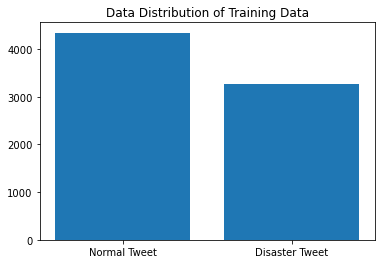

In [6]:
dist = train_df.target.value_counts()
values = [dist[0], dist[1]]
names = ["Normal Tweet", "Disaster Tweet"]
plt.figure()
plt.title("Data Distribution of Training Data")
plt.bar(names, values)

# Simple Vectorizor

For the first method, just take the data and use sklearn's CountVectorizer to convert the documents into a vector. Then use logistic regression to make a prediction. This should give us a baseline of our performance

In [7]:
from sklearn import feature_extraction
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [8]:
vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = vectorizer.fit_transform(train_df["text"])
test_vectors = vectorizer.transform(test_df["text"])

print(train_vectors.shape)
print(test_vectors.shape)

(7613, 21637)
(3263, 21637)


In [9]:
# create logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_vectors, train_df["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# print the accuracy on the training data

train_preds = model.predict(train_vectors)
train_acc = accuracy_score(train_df["target"], train_preds)
print(train_acc)

0.9675554971758834


In [11]:
# save the predictions on the testing data to submit to kaggle

df = pd.DataFrame()
test_preds = model.predict(test_vectors)
df["id"] = test_df["id"]
df["target"] = test_preds
df.to_csv("logistic_regression.csv", index=False)

Nice! That already gets us a score of 0.79987.

# Better Preprocessing

### I Implemented the following preprocessing steps

* Remove URLs
* Convert to Lowercase
* Remove Punctuation
* Remove Stop Words


### Some more ideas we could try
* Add spellchecker (tried implementing with pyspellchecker, but processing took too long)
* Do something with the emoji's
* Convert abbreviations to phrases. For example lol to laugh out loud, etc.




In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
print(STOPWORDS)

{'you', "you're", 'hadn', 'yourself', 'while', 'after', 'your', 'all', 'an', 'had', 'on', 'to', "weren't", "didn't", 'by', 'can', 'above', 'won', 'we', 'wasn', 'nor', 'not', 'am', "mustn't", 'mightn', 'about', 'no', 'a', "needn't", 'there', 'didn', 'very', 'hasn', 've', 'wouldn', "it's", 'are', 'over', 'of', 'whom', 'against', 'our', 'where', 'most', 'being', "haven't", 'do', 'further', 'few', 'and', 'itself', 'then', 'than', "hadn't", 'aren', "isn't", 'shouldn', 'been', 'out', 'having', "aren't", 'through', "hasn't", 'how', 'other', 'himself', 'at', 'more', 'just', 'd', 'were', 'this', "she's", 'too', 'was', 'yours', "that'll", 'my', 'or', 'isn', "you'd", 'will', 'once', 'doesn', 'she', 'mustn', 't', 'between', 'why', "won't", 'ours', 'any', "mightn't", 'its', 'own', 'll', "shan't", 'that', 'myself', 'but', 'because', 'which', 'so', 'yourselves', "should've", 'don', 'again', 'for', 'each', 're', 'under', 'him', 'off', "wouldn't", 'the', 'theirs', 'until', 'be', 'up', 'he', 'them', 'me

### URLs

In [14]:
# thanks to https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string for the robust regex
url_re = re.compile(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])?')
def remove_url(text):
    text = url_re.sub('', text)
    return text

In [15]:
# got this example straight from the training data
example = "Stop the Annihilation of the Salt River Wild Horses! http://t.co/wVobVVtXKg via @Change"
example = remove_url(example)
print(example)

Stop the Annihilation of the Salt River Wild Horses!  via @Change


### Lowercase

In [16]:
def convert_to_lowercase(text):
    text = text.lower()
    return text

In [17]:
example = convert_to_lowercase(example)
print(example)

stop the annihilation of the salt river wild horses!  via @change


### Punctuation

In [18]:
def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [19]:
example = remove_punctuation(example)
print(example)

stop the annihilation of the salt river wild horses  via change


### Stopwords

In [20]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [21]:
example = remove_stopwords(example)
print(example)

stop annihilation salt river wild horses via change


In [22]:
def apply_all_transformations(df):
    new_df = df.copy()
    new_df['text'] = new_df['text'].apply(remove_url)
    new_df['text'] = new_df['text'].apply(convert_to_lowercase)
    new_df['text'] = new_df['text'].apply(remove_punctuation)
    new_df['text'] = new_df['text'].apply(remove_stopwords)
    return new_df

## Preprocessed Training and Testing Data

In [23]:
new_train_df = apply_all_transformations(train_df)
new_test_df = apply_all_transformations(test_df)

# LSTM

Make sure to use GPU backend on google colab

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [25]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(new_train_df['text'].values)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

Found 17978 unique tokens


In [26]:
X_train = tokenizer.texts_to_sequences(new_train_df['text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
Y_train = new_train_df['target'].values
Y_train = Y_train.reshape((-1, 1))

X_test = tokenizer.texts_to_sequences(new_test_df['text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(7613, 100) (7613, 1)
(3263, 100)


In [27]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,042,305
Trainable params: 1,042,305
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
96/96 [==============================] - 35s 28ms/step - loss: 0.6891 - accuracy: 0.5580 - val_loss: 0.6821 - val_accuracy: 0.5345
Epoch 2/10
96/96 [==============================] - 2s 21ms/step - loss: 0.6675 - accuracy: 0.5862 - val_loss: 0.6731 - val_accuracy: 0.5345
Epoch 3/10
96/96 [==============================] - 2s 21ms/step - loss: 0.6551 - accuracy: 0.5775 - val_loss: 0.6540 - val_accuracy: 0.5706
Epoch 4/10
96/96 [==============================] - 2s 20ms/step - loss: 0.6219 - accuracy: 0.6758 - val_loss: 0.6040 - val_accuracy: 0.7242
Epoch 5/10
96/96 [==============================] - 2s 21ms/step - loss: 0.5342 - accuracy: 0.7800 - val_loss: 0.5373 - val_accuracy: 0.7525
Epoch 6/10
96/96 [==============================] - 2s 21ms/step - loss: 0.4065 - accuracy: 0.8341 - val_loss: 0.4855 - val_accuracy: 0.7800
Epoch 7/10
96/96 [==============================] - 2s 20ms/step - loss: 0.3321 - accuracy: 0.8691 - val_loss: 0.4814 - val_accuracy: 0.7735
Epoch 8/10
9

In [29]:
df = pd.DataFrame()
test_preds = np.argmax(model.predict(X_test), axis=-1)
df["id"] = test_df["id"]
df["target"] = test_preds
df.to_csv("lstm.csv", index=False)

Not very good result when I submit to kaggle. Looks like the model is overfitting. LSTM might not be best for this